# $NicheVI$

In [3]:
%load_ext autoreload
%autoreload 2

In [26]:
import torch

import anndata as ad
import numpy as np
import pandas as pd

from rich import print


from sklearn.neighbors import NearestNeighbors


import scvi

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from scib_metrics.benchmark import Benchmarker

In [5]:
!ls /home/nathanlevy/Data/

adata_MERFISH_24w.h5ad	adata_scvi_merfish4w.h5ad


In [6]:
data_dir = "/home/nathanlevy/Data/"
file = "adata_scvi_merfish4w.h5ad"

In [7]:
adata = ad.read_h5ad(data_dir + file)
print(adata)

AnnData object with n_obs × n_vars = 123632 × 374
    obs: 'fov', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'age', 'clust_annot', 'slice', 
'organism_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 
'assay_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 
'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'is_primary_data', 
'cell_type_annot', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 
'development_stage', 'donor_slice', 'n_counts', 'cell_index', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'donor_id_colors', 'log1p', 'neighbors', 'pca', 
'umap'
    obsm: 'X_pca', 'X_scVI', 'X_spVI', 'X_spatial', 'X_umap', 'centroids', 'neighborhood_composition', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## First train (linear)scVI

In [8]:
scvi.model.LinearSCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="donor_id",
)


vae = scvi.model.LinearSCVI(
    adata,
    gene_likelihood="poisson",
    n_layers=1,
    n_latent=10,
)

vae.train(
    max_epochs=50,
    train_size=0.8,
    validation_size=0.2,
    plan_kwargs=dict(n_epochs_kl_warmup=80),
    early_stopping=False,
)

adata.obsm["qz1_m"], adata.obsm["qz1_var"] = vae.get_latent_representation(
    return_dist=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [03:05<00:00,  3.73s/it, v_num=1, train_loss_step=188, train_loss_epoch=195]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [03:05<00:00,  3.72s/it, v_num=1, train_loss_step=188, train_loss_epoch=195]


/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/nathanlevy/mambaforge/envs/phenospace_23

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


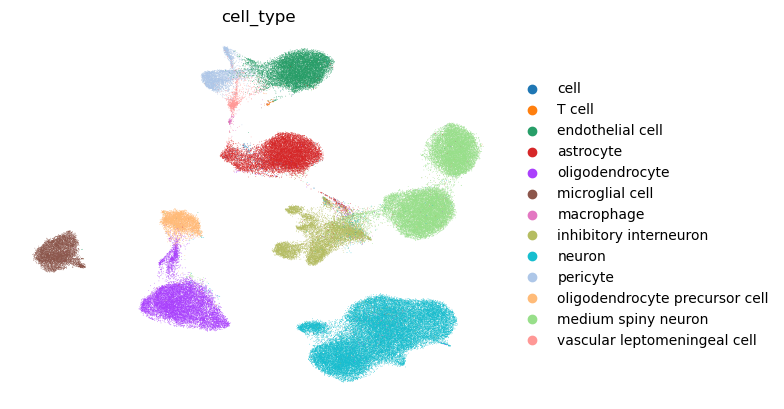

In [11]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="qz1_m")
sc.tl.umap(adata, min_dist=0.3)


sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)

<Axes: xlabel='epoch'>

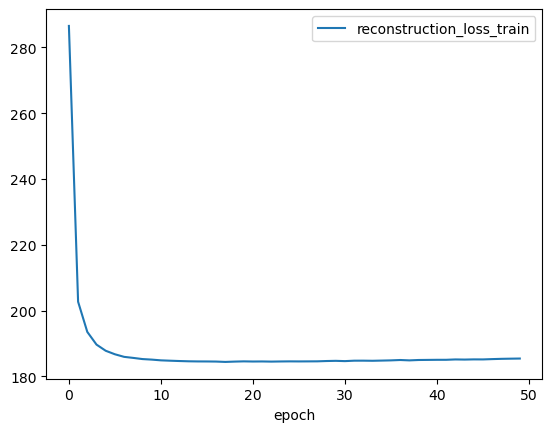

In [24]:
vae.history["reconstruction_loss_train"].plot()

## Then train $nicheVI$

In [12]:
k_nn = 20
n_latent_z1 = 10

In [13]:
adata.obsm["qz1_var"].shape  # .sum(axis=1)

(123632, 10)

In [14]:
scvi.model.nicheSCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="donor_id",
    labels_key="cell_type",
    niche_composition_key="neighborhood_composition",
    niche_indexes_key="niche_indexes",
    niche_distances_key="niche_distances",
    sample_key="donor_slice",
    cell_coordinates_key="centroids",
    k_nn=k_nn,
    latent_mean_key="qz1_m",  # USELESS
    latent_var_key="qz1_var",
)

nichevae = scvi.model.nicheSCVI(
    adata,
    z1_mean=adata.obsm["qz1_m_niches"],
    z1_var=adata.obsm["qz1_var_niches"],
    niche_kl_weight=1,
    # niche_components="ct_unweighted",
    niche_components="cell_type",
    gene_likelihood="poisson",
    n_layers=1,
    n_latent=10,
)

INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [15]:
nichevae.train(
    max_epochs=50,
    train_size=0.8,
    validation_size=0.2,
    plan_kwargs=dict(n_epochs_kl_warmup=80),
    early_stopping=False,
    batch_size=128,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 50/50: 100%|██████████| 50/50 [17:30<00:00, 21.11s/it, v_num=1, train_loss_step=185, train_loss_epoch=191]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [17:30<00:00, 21.01s/it, v_num=1, train_loss_step=185, train_loss_epoch=191]


In [16]:
adata.obsm['X_nicheVI'] = nichevae.get_latent_representation()

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


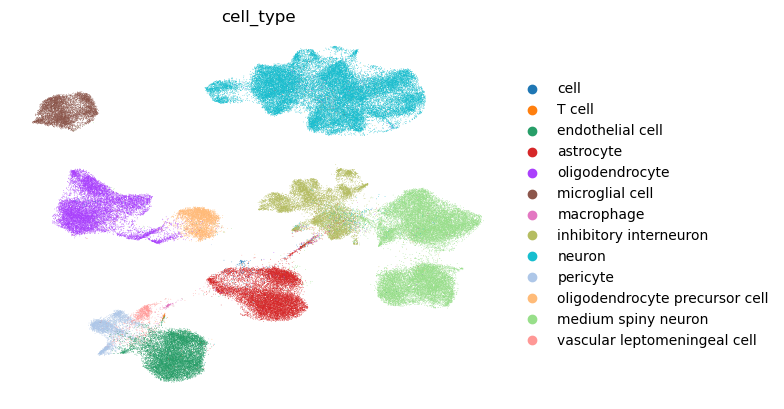

In [17]:
sc.pp.neighbors(adata, use_rep="X_nicheVI")
sc.tl.umap(adata, min_dist=0.3)


sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)

In [19]:
nichevae.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'niche_kl_train'])

<Axes: xlabel='epoch'>

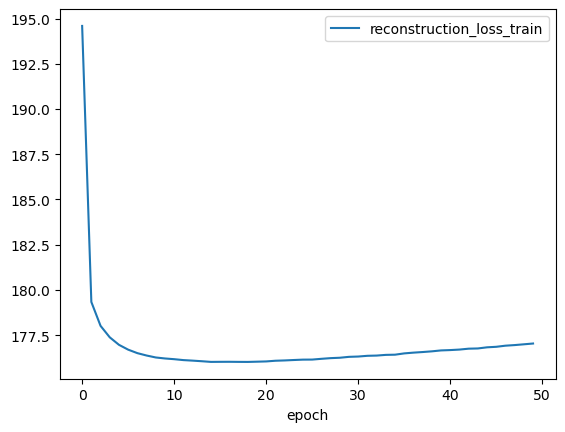

In [23]:
nichevae.history["reconstruction_loss_train"].plot()

<Axes: xlabel='epoch'>

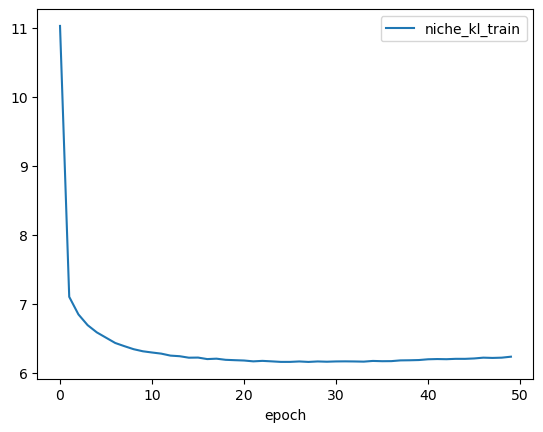

In [25]:
nichevae.history['niche_kl_train'].plot()

In [28]:
adata.obsm["X_ldvae"] = adata.obsm["qz1_m"]

bm = Benchmarker(
    adata,
    batch_key="donor_slice",
    label_key="cell_type",
    embedding_obsm_keys=["X_pca", "X_ldvae", "X_nicheVI"],
    n_jobs=6,
)
bm.benchmark()

Embeddings:  33%|███▎      | 1/3 [06:53<13:46, 413.27s/it]

In [ ]:
def get_average_latent_per_celltype(
    adata: ad.AnnData,
    labels_key: str,
    niche_indexes_key: str,
    latent_mean_key: str,
    latent_var_key: str,
    latent_mean_ct_key: str = "qz1_m_niches",
    latent_var_ct_key: str = "qz1_var_niches",
):
    # for each cell, take the average of the latent space for each label, namely the label-averaged latent_mean obsm

    n_cells = adata.n_obs
    n_latent_z1 = adata.obsm[latent_mean_key].shape[1]
    niche_indexes = adata.obsm[niche_indexes_key]

    z1_mean_niches = adata.obsm[latent_mean_key][niche_indexes]
    z1_var_niches = adata.obsm[latent_var_key][niche_indexes]

    cell_types = adata.obs[labels_key].unique().tolist()

    cell_type_to_int = {cell_types[i]: i for i in range(len(cell_types))}
    integer_vector = np.vectorize(cell_type_to_int.get)(adata.obs[labels_key])

    # For each cell, get the cell types of its neighbors
    cell_types_in_the_neighborhood = np.vstack(
        [integer_vector[niche_indexes[cell, :]] for cell in range(n_cells)]
    )

    dict_of_cell_type_indices = {}

    for cell_type, cell_type_idx in cell_type_to_int.items():
        ct_row_indices, ct_col_indices = np.where(
            cell_types_in_the_neighborhood == cell_type_idx
        )  # [1]

        # print(cell_type_idx)
        result_dict = {}
        for row_idx, col_idx in zip(ct_row_indices, ct_col_indices):
            result_dict.setdefault(row_idx, []).append(col_idx)

        dict_of_cell_type_indices[cell_type] = result_dict

    # print(dict_of_cell_type_indices)

    z1_mean_niches_ct = np.zeros(
        (n_cells, len(cell_types), n_latent_z1)
    )  # batch times n_cell_types times n_latent
    z1_var_niches_ct = np.zeros((n_cells, len(cell_types), n_latent_z1))

    for cell_type, cell_type_idx in cell_type_to_int.items():
        ct_dict = dict_of_cell_type_indices[cell_type]
        for cell_idx, neighbor_idxs in ct_dict.items():
            z1_mean_niches_ct[cell_idx, cell_type_idx, :] = np.mean(
                z1_mean_niches[cell_idx, neighbor_idxs, :], axis=0
            )
            z1_var_niches_ct[cell_idx, cell_type_idx, :] = np.mean(
                z1_var_niches[cell_idx, neighbor_idxs, :], axis=0
            )

    adata.obsm[latent_mean_ct_key] = z1_mean_niches_ct
    adata.obsm[latent_var_ct_key] = z1_var_niches_ct

    return None

In [ ]:
get_average_latent_per_celltype(
    adata,
    labels_key="cell_type",
    niche_indexes_key="niche_indexes",
    latent_mean_key="qz1_m",
    latent_var_key="qz1_var",
    latent_mean_ct_key="qz1_m_niches",
    latent_var_ct_key="qz1_var_niches",
)

In [14]:
z1_mean = adata.obsm["qz1_m"]
niche_indexes = adata.obsm["niche_indexes"]
z1_mean_niches = z1_mean[niche_indexes]

In [20]:
adata.obsm["qz1_m_niches"].shape

(123632, 13, 10)

In [19]:
niche_indexes.shape

(123632, 20)

In [ ]:
print(z1_mean_niches.shape)


cell_type_column = "cell_type"
cell_types = adata.obs[cell_type_column].unique().tolist()
cell_type_to_int = {cell_types[i]: i for i in range(len(cell_types))}
integer_vector = np.vectorize(cell_type_to_int.get)(adata.obs[cell_type_column])


n_cells = adata.n_obs
# For each cell, get the cell types of its neighbors
cell_types_in_the_neighborhood = np.vstack(
    [integer_vector[niche_indexes[cell, :]] for cell in range(n_cells)]
)


subset = cell_types_in_the_neighborhood[:5]
print(subset)
# Find the indices of elements with value 2
cell_types = [0, 1, 2, 3]
dict_of_cell_type_indices = {}

for cell_type, cell_type_idx in cell_type_to_int.items():
    ct_row_indices, ct_col_indices = np.where(subset == cell_type_idx)  # [1]
    # ct_array = subset[ct_row_indices, ct_col_indices]
    # print(ct_array)
    result_dict = {}
    for row_idx, col_idx in zip(ct_row_indices, ct_col_indices):
        result_dict.setdefault(row_idx, []).append(col_idx)

    dict_of_cell_type_indices[cell_type] = result_dict

print(dict_of_cell_type_indices)
z1_mean_niches = np.ones((5, k_nn, 1))  # batch times knn times nlatent

z1_mean_niches[0, [6, 6], :] = 2

z1_mean_niches_ct = np.zeros(
    (subset.shape[0], len(cell_type_to_int), 1)
)  # batch times ncelltypes times nlatent
# for cell_type_idx in cell_types:
for cell_type, cell_type_idx in cell_type_to_int.items():
    ct_dict = dict_of_cell_type_indices[cell_type]
    for cell_idx, neighbor_idxs in ct_dict.items():
        z1_mean_niches_ct[cell_idx, cell_type_idx, :] = np.mean(
            z1_mean_niches[cell_idx, neighbor_idxs, :], axis=0
        )
z1_mean_niches_ct[0]

(123632, 20, 10)

[[2 6 2 0 1 4 1 4 0 2 4 2 2 2 0 2 0 2 3 2]
 [2 2 2 2 2 1 6 2 2 0 2 2 4 1 2 3 0 2 3 0]
 [2 2 1 1 3 2 0 2 2 6 2 6 2 2 6 0 2 2 2 1]
 [4 2 0 2 2 4 7 2 2 7 2 0 1 2 2 2 2 0 2 1]
 [2 3 2 0 3 2 2 6 2 2 4 1 1 6 2 1 2 0 4 2]]

{
    'endothelial cell': {0: [3, 8, 14, 16], 1: [9, 16, 19], 2: [6, 15], 3: [2, 11, 17], 4: [3, 17]},
    'oligodendrocyte precursor cell': {0: [4, 6], 1: [5, 13], 2: [2, 3, 19], 3: [12, 19], 4: [11, 12, 15]},
    'neuron': {
        0: [0, 2, 9, 11, 12, 13, 15, 17, 19],
        1: [0, 1, 2, 3, 4, 7, 8, 10, 11, 14, 17],
        2: [0, 1, 5, 7, 8, 10, 12, 13, 16, 17, 18],
        3: [1, 3, 4, 7, 8, 10, 13, 14, 15, 16, 18],
        4: [0, 2, 5, 6, 8, 9, 14, 16, 19]
    },
    'astrocyte': {0: [18], 1: [15, 18], 2: [4], 4: [1, 4]},
    'inhibitory interneuron': {0: [5, 7, 10], 1: [12], 3: [0, 5], 4: [10, 18]},
    'pericyte': {},
    'oligodendrocyte': {0: [1], 1: [6], 2: [9, 11, 14], 4: [7, 13]},
    'microglial cell': {3: [6, 9]},
    'vascular leptomeningeal cell': {},
    'medium spiny neuron': {},
    'macrophage': {},
    'T cell': {},
    'cell': {}
}

array([[1. ],
       [1.5],
       [1. ],
       [1. ],
       [1. ],
       [0. ],
       [1. ],
       [0. ],
       [0. ],
       [0. ],
       [0. ],
       [0. ],
       [0. ]])

Experiments with **Niche decoder**

In [26]:
nichevae.summary_stats

n_batch: 4
n_cells: 123632
n_extra_categorical_covs: 0
n_extra_continuous_covs: 0
n_labels: 13
n_latent_mean: 10
n_latent_var: 10
n_niche_composition: 13
n_niche_distances: 20
n_niche_indexes: 20
n_vars: 374

In [27]:
print(nichevae.module.niche_decoder)

NicheDecoder(
  (decoder): FCLayers(
    (fc_layers): Sequential(
      (Layer 0): Sequential(
        (0): Linear(in_features=10, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): None
        (3): ReLU()
        (4): None
      )
    )
  )
  (mean_decoder): Linear(in_features=128, out_features=130, bias=True)
  (var_decoder): Linear(in_features=128, out_features=130, bias=True)
)

In [ ]:
latent_cell = torch.ones((2, 10), device=nichevae.device)  # (batch_size*latent_size)

niche_mean, niche_var = nichevae.module.niche_decoder(
    latent_cell
)  # (batch_size*latent_size*k_nn)

In [ ]:
nichevae.module.n_niche_components

niche_mean_mat = niche_mean.reshape(
    niche_mean.shape[0], nichevae.module.n_niche_components, n_latent_z1
)
niche_var_mat = niche_var.reshape(
    niche_var.shape[0], nichevae.module.n_niche_components, n_latent_z1
)

niche_mean_agg = torch.sum(niche_mean_mat, dim=1)
niche_var_agg = torch.sum(niche_var_mat, dim=1)

In [ ]:
niche_mean_agg.shape

torch.Size([2, 10])

## Code to train compo-scVI

In [ ]:
scvi.model.compoSCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="donor_id",
    niche_composition_key="neighborhood_composition",
)

n_cell_types = adata.obsm["neighborhood_composition"].shape[1]

compovae = scvi.model.compoSCVI(
    adata,
    gene_likelihood="poisson",
    n_layers=1,
    n_latent=15,
    n_cell_types=n_cell_types,
    ce_weight=10,
)

compovae.train(
    max_epochs=1,
    train_size=0.8,
    validation_size=0.2,
    plan_kwargs=dict(n_epochs_kl_warmup=80),
    early_stopping=False,
)

adata.obsm["ct_pred"] = compovae.predict_neighborhood(softmax=True)

INFO     Using column names from columns of adata.obsm['neighborhood_composition']                                 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/1:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1: 100%|██████████| 1/1 [00:03<00:00,  3.95s/it, v_num=1, train_loss_step=195, train_loss_epoch=209]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 1/1: 100%|██████████| 1/1 [00:03<00:00,  3.95s/it, v_num=1, train_loss_step=195, train_loss_epoch=209]
